<a href="https://colab.research.google.com/github/ayush-2405/Stock-Market-Prediction/blob/main/LSTM_Model_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

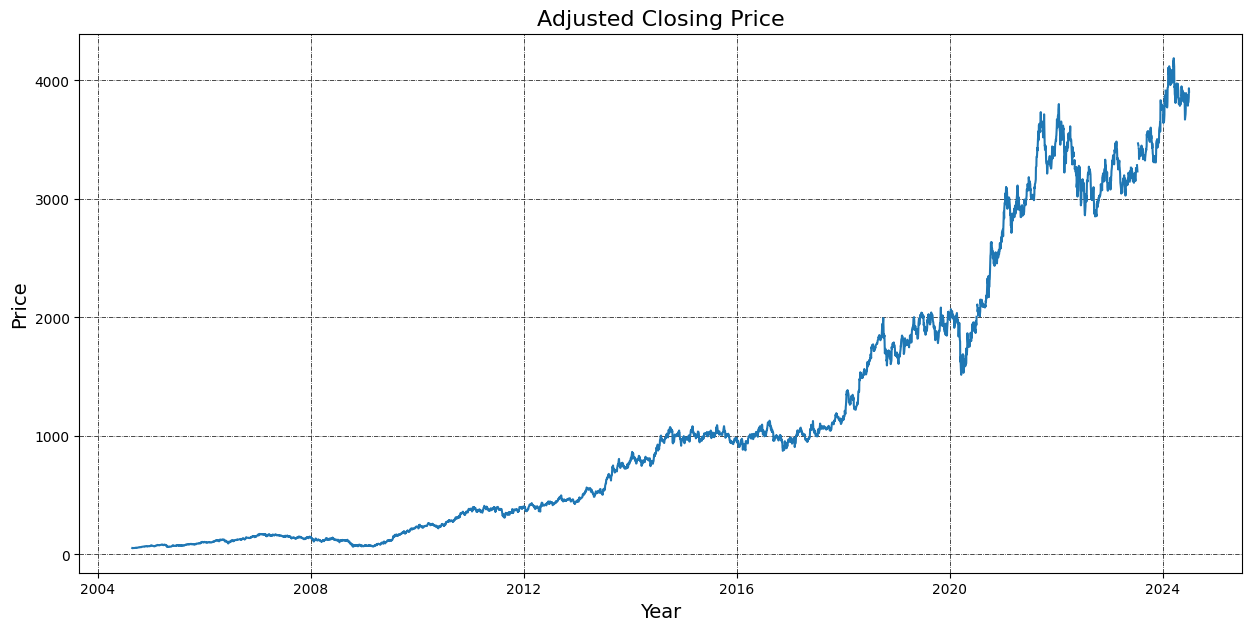

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

ds=pd.read_csv('TCS.BO.csv')

ds=ds[['Date','Adj Close']]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

ds['Date'] = pd.to_datetime(ds['Date'])

plt.figure(figsize=(15,7))
plt.plot(ds['Date'], ds['Adj Close'], )
plt.title("Adjusted Closing Price", fontsize=16)

plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()



In [2]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Adj Close(t-{i})'] = df['Adj Close'].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 7
shifted_ds = prepare_dataframe_for_lstm(ds, lookback)
shifted_ds

,Adj Close,Adj Close(t-1),Adj Close(t-2),Adj Close(t-3),Adj Close(t-4),Adj Close(t-5),Adj Close(t-6),Adj Close(t-7)
Date,,,,,,,,
2004-09-03,54.901997,54.654423,54.343582,54.351841,54.258308,52.943459,53.834679,54.327061
2004-09-06,54.739674,54.901997,54.654423,54.343582,54.351841,54.258308,52.943459,53.834679
2004-09-07,54.758942,54.739674,54.901997,54.654423,54.343582,54.351841,54.258308,52.943459
2004-09-08,54.657169,54.758942,54.739674,54.901997,54.654423,54.343582,54.351841,54.258308
2004-09-09,53.914474,54.657169,54.758942,54.739674,54.901997,54.654423,54.343582,54.351841
...,...,...,...,...,...,...,...,...
2024-06-24,3817.300049,3808.949951,3786.600098,3801.100098,3814.750000,3831.949951,3877.500000,3832.399902
2024-06-25,3839.100098,3817.300049,3808.949951,3786.600098,3801.100098,3814.750000,3831.949951,3877.500000
2024-06-26,3856.050049,3839.100098,3817.300049,3808.949951,3786.600098,3801.100098,3814.750000,3831.949951


In [4]:
shifted_ds_in_np = shifted_ds.to_numpy()

shifted_ds_in_np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
shifted_ds_in_np = scaler.fit_transform(shifted_ds_in_np)

shifted_ds_in_np

X= shifted_ds_in_np[:,1:]
Y=shifted_ds_in_np[:,0]

X.shape, Y.shape
import numpy as np
from copy import deepcopy as dc
X = dc(np.flip(X, axis=1))

split_index = int(len(X) * 0.90)

X_train = X[:split_index]
X_test = X[split_index:]

Y_train = y[:split_index]
Y_test = y[split_index:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4240, 7), (472, 7), (4240,), (472,))

In [5]:
shifted_ds_in_np.shape

(4712, 8)

In [6]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = Y_train.reshape((-1, 1))
y_test = Y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4240, 7, 1), (472, 7, 1), (4240, 1), (472, 1))

In [7]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4240, 7, 1]),
 torch.Size([472, 7, 1]),
 torch.Size([4240, 1]),
 torch.Size([472, 1]))

In [8]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [48]:
from torch.utils.data import DataLoader

batch_size = 128
learning_rate = 0.001
num_epochs = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 7, 1]) torch.Size([128, 1])


In [49]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout_prob=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        out = self.fc(out[:, -1, :])

        return out

# dropout regularization
dropout_prob = 0.2  # Set dropout probability (e.g., 20% dropout)
model = LSTM(input_size=1, hidden_size=16, num_stacked_layers=2, dropout_prob=dropout_prob)
model.to(device)  # Move model to GPU or CPU

#L2 regularization
l2_lambda = 0.01  # Set L2 regularization strength (lambda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

model = LSTM(1, 16, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [50]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [51]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [52]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.285
***************************************************

Epoch: 2

Val Loss: 0.001
***************************************************

Epoch: 3

Val Loss: 0.002
***************************************************

Epoch: 4

Val Loss: 0.001
***************************************************

Epoch: 5

Val Loss: 0.001
***************************************************



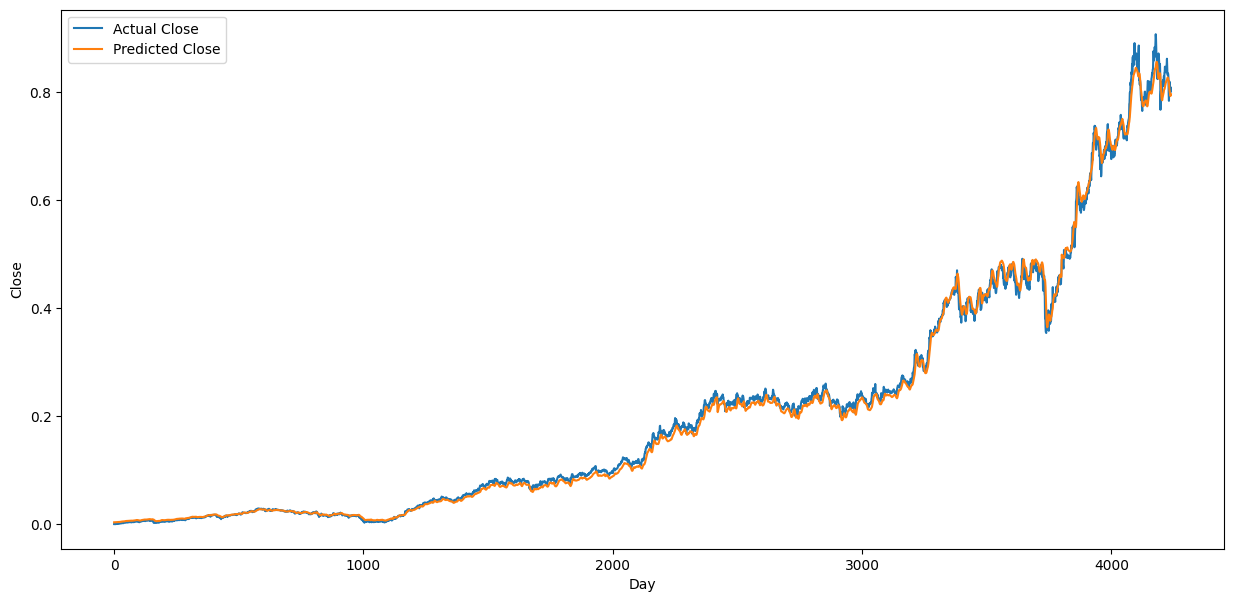

In [53]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(15,7))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [54]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  68.62193398,   68.68530882,   68.82640869, ..., 3327.38965033,
       3331.94278495, 3341.62798864])

In [55]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  54.90199701,   54.73967403,   54.75894199, ..., 3373.26540096,
       3394.76677979, 3362.65685842])

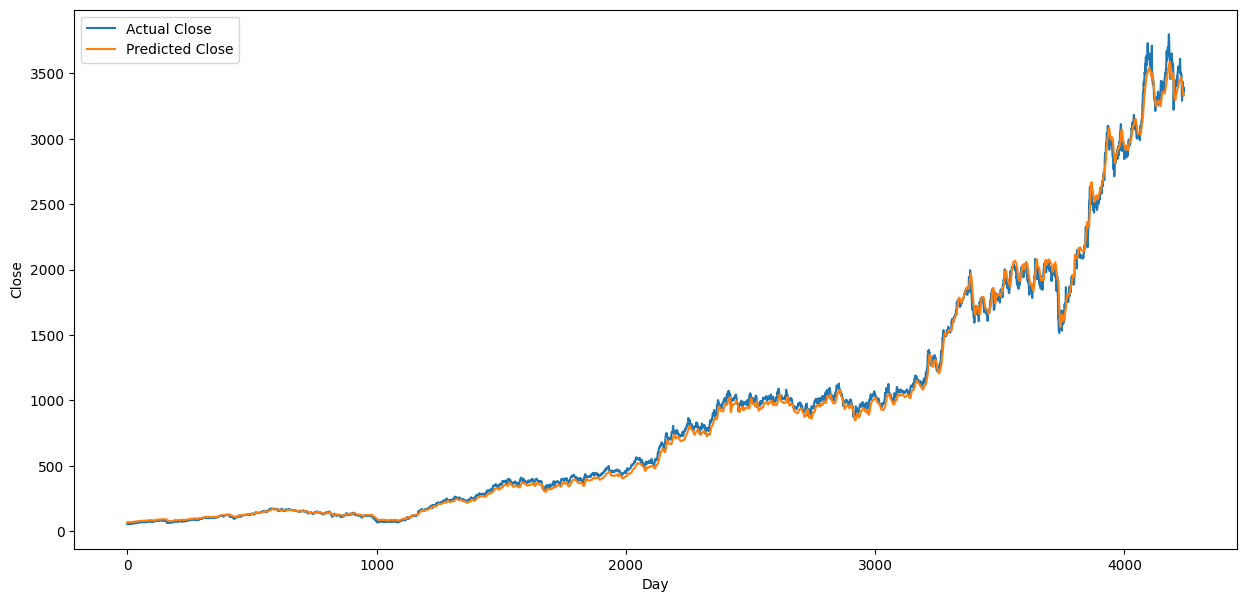

In [56]:

plt.figure(figsize=(15,7))
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [57]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([3247.2503422 , 3238.37367589, 3224.7132866 , 3223.07157633,
       3221.92947417, 3212.01023316, 3200.73702461, 3188.61635459,
       3173.60396861, 3154.39024306, 3128.00610651, 3106.30320922,
       3112.92720466, 3121.41216639, 3130.20063758, 3148.91179875,
       3180.68421366, 3205.27784148, 3220.7282468 , 3224.2481682 ,
       3229.97690928, 3232.53407503, 3217.1605325 , 3193.9445223 ,
       3167.86980772, 3142.12274541, 3105.31138366, 3065.51616915,
       3040.25491906, 3036.10827032, 3042.18954552, 3053.87835509,
       3076.7312379 , 3106.19629111, 3129.80991842, 3138.94772111,
       3147.48786638, 3142.00252413, 3134.62960924, 3126.01949913,
       3119.37579528, 3116.10075082, 3105.9050994 , 3083.77132707,
       3063.0511402 , 3037.06560617, 3002.16595985, 2968.23054733,
       2942.3859284 , 2943.60144437, 2954.86233517, 2974.75600074,
       2998.85494755, 3018.73013649, 3032.43166708, 3048.96504933,
       3061.32788641, 3076.01976442, 3093.12419776, 3114.33438

In [58]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([3233.22165206, 3198.36462517, 3269.925603  , 3266.89445007,
       3098.00867996, 3119.98379962, 3145.6054672 , 3114.44253476,
       3019.60937778, 3078.73114845, 3110.77159769, 3218.86038256,
       3208.6090549 , 3200.69391247, 3264.05964214, 3279.17401912,
       3271.02114405, 3205.93881217, 3245.08364925, 3267.49260021,
       3209.13354487, 3070.67336644, 3062.18668022, 3057.94346029,
       2996.48476531, 2945.84968085, 2968.68778236, 3062.90184902,
       3072.43776153, 3155.39882077, 3140.09401131, 3158.87957172,
       3164.88669404, 3138.28231604, 3113.67981943, 3162.21694401,
       3084.50004541, 3066.8590507 , 3108.95990242, 3134.37290724,
       3113.29846176, 2968.73557525, 2941.46308226, 2897.50348146,
       2867.05152979, 2862.12787712, 2925.99493938, 2940.09753605,
       3025.04668079, 3038.19317338, 3031.78695583, 3028.24929686,
       2979.0588386 , 3048.37552162, 3117.07138984, 3155.88882103,
       3154.35895597, 3145.61064066, 3192.98546196, 3206.89639

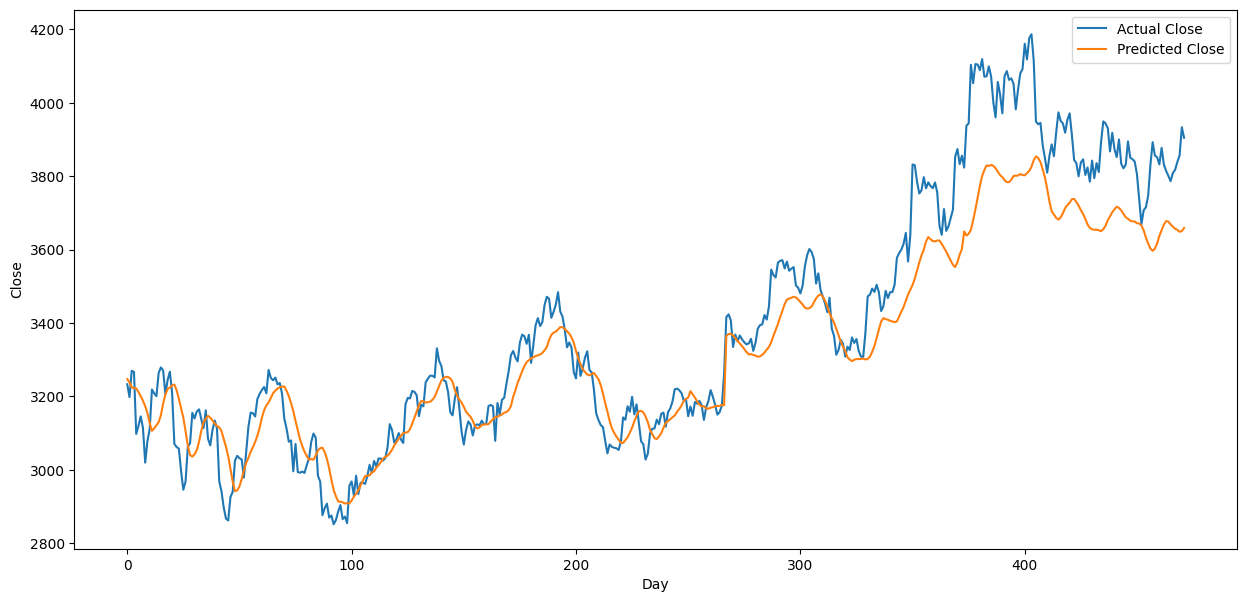

In [59]:
plt.figure(figsize=(15,7))

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(new_y_test, test_predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 97.54
